/home/munier/mambaforge/envs/deepinv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/munier/mambaforge/envs/deepinv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-09-12 17:08:00.847346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 17:08:00.908462: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performa

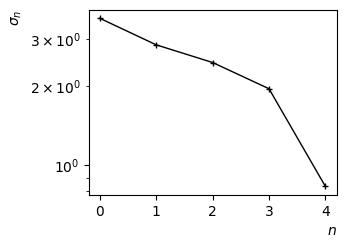

param| pos:[79,], iter: 0, loss: 5.711e-10, snr: 107.880, grad: 3.807e-05:  56%|█████▋    | 57/101 [33:34<27:23, 37.34s/it]

In [ ]:
# ########################################################
# ################# JACKPOT TEMPLATE #####################
# ########################################################

import torch
from jackpot import Jackpot

params = {
    "experiment_name": "jmlr_blind_inverse_problem",
    "save_plot": True,
    "n_singular_pairs": 5,
    "max_compute_time": 3600,
    "load_sing_pairs": False,
    "save_sing_pairs": True,
    "D": 1,
    "epsilon": 1e-1,
    "n_points_per_axis": 101,
    "grid_length": 1e-4,
    "load_manifold": False,
    "save_manifold": True,
}

# ------------------------------------
#  DIRECT MODEL 
# ------------------------------------

import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from pathlib import Path

import deepinv as dinv
# from utils_codes.utils import neurips_mode, default_plot_styles, save_this_plot

######## IMPORT THE MODEL #################################
from article_examples.blind_inv_pb.deblur_simple import Deblurring

import imageio.v3 as iio

from tqdm import tqdm
import os

# Device & dtype setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64
factory_kwargs = {"device": device, "dtype": dtype}
torch.manual_seed(0)

# Example: Blind inverse problem
img_size = 100 # 400
image_filename = "blob3.jpg"
max_iter_DPIR = 10
i_max_zernike = 12
psf_size = 51

num_workers = 8
batch_size = 1

PATH = Path("./dataset/")
image_name = image_filename[:-4]
img_filename = PATH / Path(image_filename)

def load_image(img_name, img_size = None):
    im = iio.imread(img_name)
    if len(im.shape) == 2:
        im = im[:,:,None]
    
    im = (torch.tensor(im, device = device, dtype = dtype)[:,:,:3] *  
            torch.ones((1,1,3), device = device, dtype = dtype)) /255
    im = im.permute((2,0,1))[None,...]
    
    if img_size != None:
        im = im[:,:,:img_size,:img_size]
    
    return im


x = load_image(img_filename, img_size = img_size)

deblur_model = Deblurring(device = device, dtype = dtype)
deblur_model.set_variables(img_size = img_size, batch_size = batch_size,
                           num_workers = num_workers, max_iter_DPIR = max_iter_DPIR,
                           i_max_zernike = i_max_zernike, psf_size = psf_size)

x, theta_star, y = deblur_model.generate_random_coeffs(x = x)

sigma_noise = deblur_model.noise_level_img
deblur_model.set_model(y)
Phi = deblur_model.Phi
x_est = theta_star
# ------------------------------------


# ------------------------------------
# JACKPOT INITIALIZATION
# ------------------------------------
jack = Jackpot(Phi, x_est)

jack.set_params(**params)
# ------------------------------------


# ------------------------------------
# JACOBIAN SINGULAR SPECTRUM
# ------------------------------------
jack.jacobian_spectrum()

# Plot spectrum
jack.jacobian_spectrum_plot()
# ------------------------------------


# ------------------------------------
# JACKPOT MANIFOLD
# ------------------------------------
jack.manifold()

# Plot discrepancy
jack.plot_discrepancy(
    in_SNR=True,
    levels=[20, 30, 40],
    color_levels=["g", "b", "r"],
)
# ------------------------------------